# Puzzle Solver 🧩

In [57]:
# Don't worry about it it just used for easier coding:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [58]:
# path of dataset change with your own path
folder_path = r"Puzzle_2_160"

In [59]:
#Read Images
output_file = os.path.join(folder_path, "Output.tif")
patch_files = glob.glob(os.path.join(folder_path, "Patch_*.tif"))

corners_img = np.array(Image.open(output_file))
# Get copy of image to edit it later
base_img = corners_img.copy()

patches = [np.array(Image.open(patch_file)) for patch_file in patch_files]

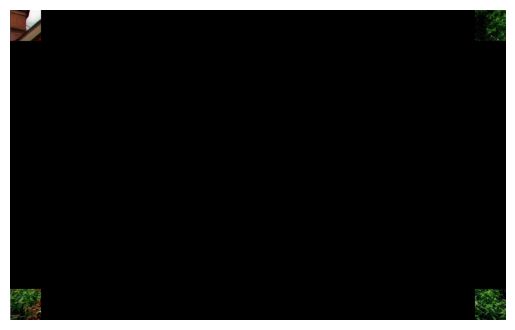

In [60]:
plt.imshow(base_img)
plt.axis('off')
plt.show()

In [61]:
# Now it's time to find what's our final image good base on original image

# This properties are determined according to the dataset:
rows, cols = 5, 8
img_width, img_height = 1920, 1200
#patch_width, patch_height = img_width // cols, img_height // rows
patch_width , patch_height , _ = patches[0].shape
rows = img_height // patch_height
cols = img_width // patch_width

In [62]:
def get_right_edge(patch):
    return patch[:, -1]

In [63]:
def get_left_edge(patch):
    return patch[:, 0]

In [64]:
def get_top_edge(patch):
    return patch[0,:]

In [65]:
def get_down_edge(patch):
    return patch[-1,:]

In [66]:
def calculate_mse(edge1, edge2):
    edge1 = edge1.astype(np.float64)
    edge2 = edge2.astype(np.float64)
    return np.mean((edge1 - edge2) ** 2)

In [67]:
# TODO:
# Now you should solve puzzle do it the best you can.
def puzzle_solver():
    # Store final image - change the code as you needed.
    final_img = base_img.copy()
    remainPatch = list(range(len(patches)))
    corners_placed = [final_img[0:patch_height , 0:patch_width] , final_img[0:patch_height , (cols-1)*patch_width : cols*patch_width] , final_img[(rows-1)*patch_height :rows*patch_height , 0:patch_width] , final_img[(rows-1)*patch_height , (cols-1) * patch_width]]
    usedIndices = []
    for corner_patch in corners_placed:
      for i in remainPatch:
        if i not in usedIndices and np.array_equal(patches[i] , corner_patch):
          usedIndices.append(i)
          break
        
    remainPatch = [i for i in remainPatch if i not in usedIndices]
        
    while len(remainPatch)>0 :
      #p_moves = []
      confidence_moves = []
      for r in range(rows):
        for c in range(cols):
          #if np.all(final_img[r*patch_height:(r+1)*patch_height, c*patch_width:(c+1)*patch_width]==0):
          if not np.any(final_img[r * patch_height : (r+1) * patch_height , c*patch_width:(c+1)* patch_width]):
            slot_errors = []  
            # best_patch = -1
            # min_error= float('inf')
            for p_index in remainPatch:
              patch = patches[p_index]
              total_error = 0
              if r > 0:
                n_high= final_img[(r-1)*patch_height:r*patch_height, c*patch_width:(c+1)*patch_width]
                total_error += calculate_mse(get_top_edge(patch), get_down_edge(n_high))
              if c > 0:
                n_left = final_img[r*patch_height:(r+1)*patch_height, (c-1)*patch_width:c*patch_width]
                total_error+= calculate_mse(get_left_edge(patch), get_right_edge(n_left))
              # if total_error < min_error:
              #   min_error = total_error
              #   best_patch = p_index
              slot_errors.append((total_error , p_index))
            
            slot_errors.sort(key=lambda x: x[0])
            if len(slot_errors) >=2 :
              best_match = slot_errors[0]
              second_best_match = slot_errors[1]
              best_error = best_match[0]
              second_best_error = second_best_match[0]
              ratio = second_best_error / (best_error + 1e-6)
              confidence_moves.append((ratio, r, c, best_match[1]))
            elif len(slot_errors) == 1:
              best_match = slot_errors[0]
              ratio = float('inf') 
              confidence_moves.append((ratio , r , c , best_match[1]))
            

      best_overall_move = max(confidence_moves, key=lambda x: x[0])
      #min_err, r_best, c_best, patch_idx_best = best_overall_move
      max_ratio , r_best , c_best , patch_idx_best = best_overall_move
      patch_to_place = patches[patch_idx_best]
      final_img[r_best*patch_height:(r_best+1)*patch_height, c_best*patch_width:(c_best+1)*patch_width] = patch_to_place

      remainPatch.remove(patch_idx_best)
    return final_img

In [68]:
# Test and Save final Image
final_img = puzzle_solver()
Image.fromarray(final_img).save(os.path.join(folder_path, "final.tif"))

In [69]:
def accuracy_block_base(original_img, final_img, rows, cols):
    correct_blocks = 0
    total_blocks = rows * cols
    for row in range(rows):
        for col in range(cols):
            patch = final_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]
            original_patch = original_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]

            if np.array_equal(patch, original_patch):
                correct_blocks += 1

    return 100 * correct_blocks / total_blocks

original_img = np.array(Image.open(os.path.join(folder_path, "Original.tif")))
accuracy= accuracy_block_base(original_img, final_img, rows, cols)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 75.62%


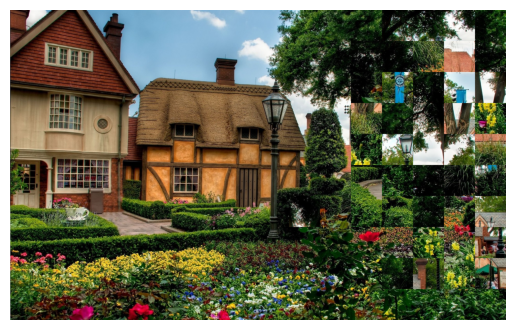

In [70]:
# show final_img - You can make animation for it while solving puzzle. That's fun!
plt.imshow(final_img)
plt.axis('off')
plt.show()